## **ANALYSIS OF THE EFFECTIVENESS OF TWO LANDING PAGE VARIANTS**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта и провела A/B-тестирование. В результате эксперимента были собраны данные.

*Бизнес-задача*: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям — конверсии покупки и ежедневному среднему чеку.



*   A/B-тестирование было проведено корректно
*   проверить факт стабилизации метрик и обоснованно ответить на ключевой вопрос турагентства: какой вариант посадочной страницы более предпочтителен по метрикам конверсии и ежедневного среднего чека?


Компания предлагает следующие варианты туров:

*Санкт-Петербург* — 10 000 рублей; \
*Турция* — 60 000 рублей; \
*Таиланд* — 100 000 рублей; \
*Камчатка* — 150 000 рублей; \
*Мальдивы* — 200 000 рублей.

Таблица представлена следующими полями:

**user_id** — идентификатор пользователя, зашедшего на сайт; \
**data** — дата посещения сайта; \
**group** — группа теста (контрольная — А или тестовая — B); \
**purchase** — признак покупки: совершил ли пользователь покупку тура (1 — да, 0 — нет); \
**price** — цена купленного тура (если покупка не состоялась, цена равна 0).

In [1]:
#standard libraries
import pandas as pd, numpy as np

#visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('seaborn-v0_8')

from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
from scipy.stats import shapiro

from scipy.stats import norm
from scipy.stats import t
from statsmodels.stats import proportion

### **STEP 1**

Проанализируйте структуру данных и проведите их предобработку:

* исследуйте структуру данных

In [2]:
data = pd.read_csv('data/ab_data_tourist.csv')
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


* преобразуйте столбцы к необходимым типам данных.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   user_id   294478 non-null  int64 
 1   date      294478 non-null  object
 2   group     294478 non-null  object
 3   purchase  294478 non-null  int64 
 4   price     294478 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 11.2+ MB


In [4]:
data['group'] = data['group'].astype('string')
data['purchase'] = data['purchase'].astype('int8')
data['date'] = pd.to_datetime(data['date'],
                              format='%Y-%m-%d')

* Убедитесь в одинаковой длительности проведения A/B-тестирования в каждой из групп. Если длительность разная, унифицируйте данные, удалив лишние данные для соответствующей группы.

In [5]:
groupA_start_date, groupA_end_date = data[data['group'] == 'A']['date'].dt.date.min(), data[data['group'] == 'A']['date'].dt.date.max()
groupB_start_date, groupB_end_date = data[data['group'] == 'B']['date'].dt.date.min(), data[data['group'] == 'B']['date'].dt.date.max()

print(f'Длительность Тестирования в Группе A: {groupA_start_date, groupA_end_date}')
print(f'Длительность Тестирования в Группе B: {groupB_start_date, groupB_end_date}')
print()
print(groupA_end_date - groupA_start_date, groupB_end_date - groupB_start_date, sep=', ')

Длительность Тестирования в Группе A: (datetime.date(2021, 1, 2), datetime.date(2021, 1, 24))
Длительность Тестирования в Группе B: (datetime.date(2021, 1, 2), datetime.date(2021, 1, 24))

22 days, 0:00:00, 22 days, 0:00:00


In [6]:
grouping_by_date = data.groupby('group')['date'].describe()
grouping_by_date

,count,mean,min,25%,50%,75%,max
group,,,,,,,
A,147202,2021-01-13 01:55:49.470795520,2021-01-02 00:00:00,2021-01-08 00:00:00,2021-01-13 00:00:00,2021-01-19 00:00:00,2021-01-24 00:00:00
B,147276,2021-01-13 01:23:47.034955008,2021-01-02 00:00:00,2021-01-08 00:00:00,2021-01-13 00:00:00,2021-01-19 00:00:00,2021-01-24 00:00:00


Выборки A/B-теста не обязательно должны быть одинакового размера, но обычно рекомендуется сохранять их относительно равными для оптимальных результатов. Хотя неравные размеры образцов все еще могут давать достоверные результаты, они могут привести к снижению мощности и потенциально потребовать более длительных периодов тестирования для достижения статистически значимых результатов.

In [7]:
round(100 - (data[data['group'] == 'A'].shape[0] / data[data['group'] == 'B'].shape[0] * 100), 5)

0.05025

Разница в выборках только 5% - незначительна, удалять данные из группы B не обязательно.

* Проверьте данные на наличие пропусков и избавьтесь от них, если нужно.

In [8]:
#check that there are no null values in the data set
data.isnull().sum()[data.isnull().sum() > 0]

Series([], dtype: int64)

* Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе группы. \
** Если да, исключите пользователей, оказавшихся в обеих группах.

In [9]:
#group by user id and find if there are any users in both groups
user_cnt = data.groupby('user_id')['group'].count().reset_index()
user_cnt['group'].unique()

array([1, 2])

In [10]:
group_intersect = user_cnt[user_cnt['group'] == 2]
f'Кол-во пользователей в обеих группах: {group_intersect.shape[0]}'

'Кол-во пользователей в обеих группах: 3894'

In [11]:
#convert to list
both_groups = group_intersect['user_id'].to_list()

#deselect any users with 
testing_data = data[~data['user_id'].isin(both_groups)]

#difference in observations
f'Разница в Выборках: {testing_data.shape[0], data.shape[0]}'

'Разница в Выборках: (286690, 294478)'

### **STEP 2**

Сделайте первичный анализ результатов A/B-тестирования:

* Рассчитайте вспомогательные показатели для контрольной и тестовой групп: \
** количество посещений сайта; \
** суммарное количество совершённых покупок; \
** сумма всех покупок.

In [12]:
visitationA, visitationB = testing_data[testing_data['group'] == 'A'].shape[0], testing_data[testing_data['group'] == 'B'].shape[0]
purchasesA, purchasesB = testing_data[testing_data['group'] == 'A']['purchase'].sum(), testing_data[testing_data['group'] == 'B']['purchase'].sum()
costA, costB = testing_data[testing_data['group'] == 'A']['price'].sum(), testing_data[testing_data['group'] == 'B']['price'].sum()

auxiliary_indicators = pd.DataFrame({
    'Group': ['Group A', 'Group B'],
    'Visitation': [visitationA, visitationB],
    'Purchase': [purchasesA, purchasesB],
    'Cost': [costA, costB],
})

auxiliary_indicators

,Group,Visitation,Purchase,Cost
0,Group A,143293,17220,1396120000
1,Group B,143397,17025,1510100000


* Сделайте промежуточные выводы по построенной таблице. \
** Сопоставимо ли количество посещений обоих вариантов посадочной страницы? \
** Можно ли говорить о сбалансированности выборок?

In [13]:
print(f'Разница в кол-ве посещений сайта между группами: {round(100 - abs(visitationA / visitationB * 100), 2)}%')
print(f'Разница в сум. кол-ве совершенных покупок между группами: {round(100 - abs(purchasesA / purchasesB * 100), 2)}%')
print(f'Разница в сумме всех покупок между группами: {round(100 - abs(costA / costB * 100), 2)}%')

Разница в кол-ве посещений сайта между группами: 0.07%
Разница в сум. кол-ве совершенных покупок между группами: -1.15%
Разница в сумме всех покупок между группами: 7.55%


**Вывод**: \
Посещаемость сайта (0.07%) не много выше в группе B, а так же сумма покупок (7.55%), однако кол-во совершенных покупок туров немного выше (1.15%) в группе A. Если приоритетная цель состоит в повышении суммы покупки, то можно сосредоточиться на внедрении нового варианта посадочной страницы.

* В каждой из групп рассчитайте ключевые показатели: \
** конверсия; \
** средний чек.

In [14]:
conversionA, conversionB = round(purchasesA / visitationA, 5), round(purchasesB / visitationB, 5)
av_billA, av_billB = round(costA / purchasesA, 0), round(costB / purchasesB, 0)

key_indicators = pd.DataFrame({
    'Group': ['Group A', 'Group B'],
    'Conversion': [conversionA, conversionB],
    'Average Bill': [av_billA, av_billB],
})

key_indicators

,Group,Conversion,Average Bill
0,Group A,0.12017,81075.0
1,Group B,0.11873,88699.0


* Сделайте первичные выводы о результатах A/B-тестирования на основе показателей конверсии и среднего чека в каждой из групп. \
** По какому(-им) показателю(-ям), на первый взгляд, вариант А эффективнее варианта B и наоборот?

In [15]:
print(f'Сравнение коэффициентов конверсии между группами A и B: {round(abs(conversionA - conversionB) / ((conversionA + conversionB) / 2) * 100, 2)}%')
print(f'Сравнение среднего чека между группами A и B: {round(abs(av_billA - av_billB) / ((av_billA + av_billB) / 2) * 100, 2)}%')

Сравнение коэффициентов конверсии между группами A и B: 1.21%
Сравнение среднего чека между группами A и B: 8.98%


**Вывод**: \
У группы А коэффициент конверсии немного выше (1.21%), но у группы В средний чек больше (8.98%).

* Сравните варианты A/B по покупательской способности каждого из туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. Визуализируйте полученную сводную таблицу.

In [16]:
def find_tours(table: pd.DataFrame):
    if table['price'] == 10000:
        return 'Санкт-Петербург'
    elif table['price'] == 60000:
        return 'Турция'
    elif table['price'] == 100000:
        return 'Таиланд'
    elif table['price'] == 150000:
        return 'Камчатка'
    elif table['price'] == 200000:
        return 'Мальдивы'
    else:
        return None

testing_data['tour'] = testing_data.apply(find_tours,
                                         axis=1)

/var/folders/0j/pqz07rqd22q5j3qyrrpztqnr0000gn/T/ipykernel_21910/4209428308.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_data['tour'] = testing_data.apply(find_tours,


In [17]:
p_table = pd.pivot_table(testing_data, 
                         values='purchase',
                         index='group',
                         columns='tour',
                         aggfunc='count')

p_table

tour,Камчатка,Мальдивы,Санкт-Петербург,Таиланд,Турция
group,,,,,
A,3430,1691,5096,1807,5196
B,3388,1671,5118,5141,1707


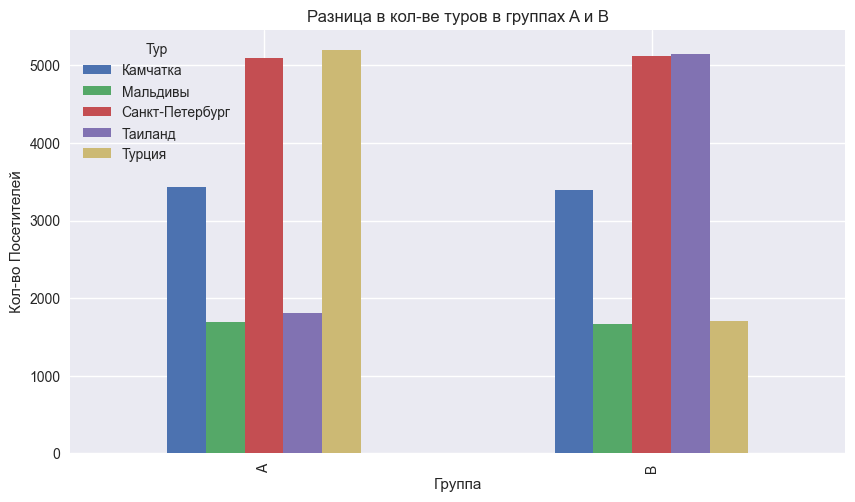

In [18]:
p_table.plot(kind='bar',
             figsize=(10, 5.5))

plt.title('Разница в кол-ве туров в группах A и B')
plt.xlabel('Группа')
plt.ylabel('Кол-во Посетителей')
plt.legend(title='Тур');

* Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем покупательская способность участников группы B, и наоборот?

**Вывод**: \
Участники обеих групп демонстрируют схожий тип покупательского поведения во всех турах — аналогичные покупки сделаны для Санкт-Петербурга, Камчатки, Мальдив. Однако у Группы А больше туров в Турцию, а у Группы В — в Таиланд. Это объясняет более высокий средний чек для Группы В, так как тур в Таиланд стоит на 40 тыс. дороже, чем тур в Турцию.

### **STEP 3**

Проанализируйте данные на предмет стабилизации метрик:

* Сгруппируйте данные по дате и группе тестирования и постройте таблицу с ежедневными данными результатов проведения A/B-тестирования. В каждой группе вычислите ежедневные показатели: \
** количество посещений страницы; \
** количество покупок; \
** сумму покупок.

In [19]:
daily_groupings = testing_data.groupby(['date', 'group']).agg({'user_id': 'count',
                                                               'purchase': 'sum',
                                                               'price': 'sum'}).reset_index()

daily_groupings = daily_groupings.rename(columns={
    'user_id': 'number_of_page_visits',
    'purchase': 'number_of_purchases',
    'price': 'amount_of_purchases'
})

daily_groupings.head(4)

,date,group,number_of_page_visits,number_of_purchases,amount_of_purchases
0,2021-01-02,A,2813,354,29170000
1,2021-01-02,B,2818,336,29050000
2,2021-01-03,A,6494,738,61420000
3,2021-01-03,B,6531,745,65030000


* Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и о ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок).

In [20]:
#daily_groupings['conversion'] = (daily_groupings['number_of_purchases'] / daily_groupings['number_of_page_visits']) * 100
daily_groupings['conversion'] = (daily_groupings['number_of_purchases'] / daily_groupings['number_of_page_visits'])

daily_groupings['average_bill'] = daily_groupings['amount_of_purchases'] / daily_groupings['number_of_purchases']

daily_groupings.head(4)

,date,group,number_of_page_visits,number_of_purchases,amount_of_purchases,conversion,average_bill
0,2021-01-02,A,2813,354,29170000,0.125844,82401.129944
1,2021-01-02,B,2818,336,29050000,0.119233,86458.333333
2,2021-01-03,A,6494,738,61420000,0.113643,83224.932249
3,2021-01-03,B,6531,745,65030000,0.114071,87288.590604


* Рассчитайте кумулятивные показатели: \
** кумулятивное количество посещений страницы; \
** кумулятивное количество покупок; \
** кумулятивную сумму покупок.

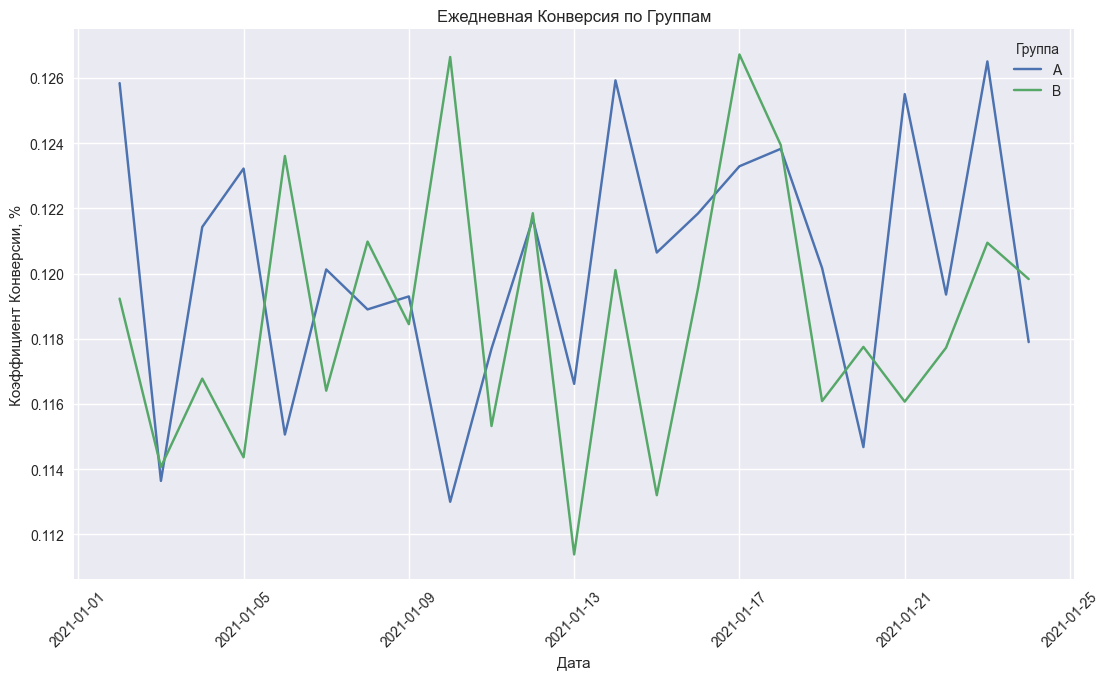

In [21]:
fig = plt.figure(figsize=(10, 5.5))

#coordinate system
ax = fig.add_axes([1, 1, 1, 1])

sns.lineplot(data=daily_groupings,
             x='date',
             y='conversion',
             hue='group',
             ax=ax)

ax.set_title('Ежедневная Конверсия по Группам')
ax.set_xlabel('Дата')
ax.set_ylabel('Коэффициент Конверсии, %')
plt.legend(title='Группа');
ax.xaxis.set_tick_params(rotation=45)
ax.grid(True);

In [22]:
daily_groupings['cum_visits'] = daily_groupings.groupby('group')['number_of_page_visits'].cumsum()
daily_groupings['cum_purchases'] = daily_groupings.groupby('group')['number_of_purchases'].cumsum()
daily_groupings['cum_cost'] = daily_groupings.groupby('group')['amount_of_purchases'].cumsum()

* На основе полученных кумулятивных показателей вычислите кумулятивную конверсию и кумулятивный средний чек.

In [23]:
#daily_groupings['cum_conversion'] = (daily_groupings['cum_purchases'] / daily_groupings['cum_visits'] * 100)
daily_groupings['cum_conversion'] = (daily_groupings['cum_purchases'] / daily_groupings['cum_visits'])

daily_groupings['cum_av_bill'] = (daily_groupings['cum_cost'] / daily_groupings['cum_purchases'])

* Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням.

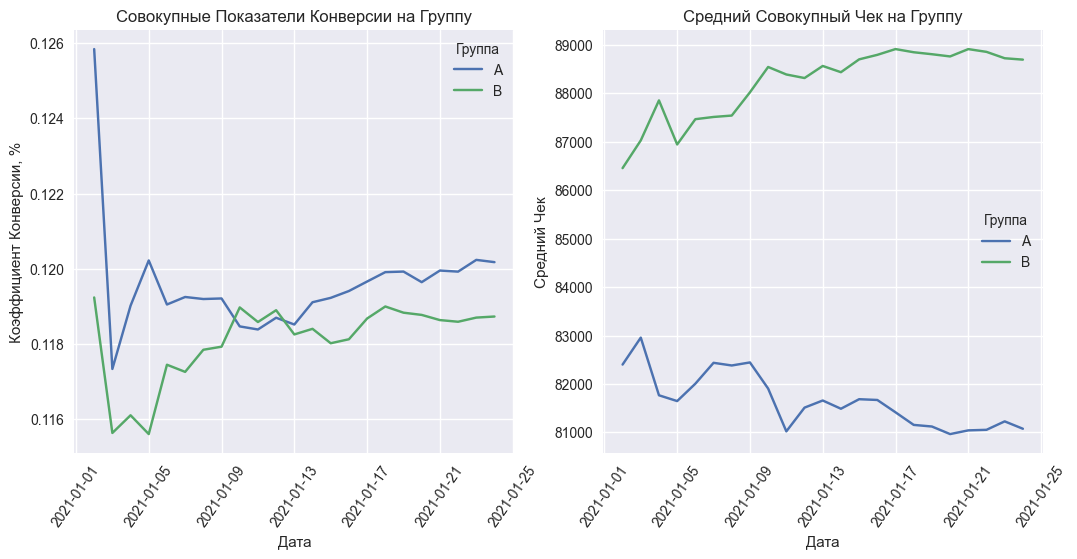

In [24]:
fig, ax = plt.subplots(1, 2,
                       figsize=(12.5, 5.5))

#line chart for conversion
sns.lineplot(data=daily_groupings, 
             x='date',
             y='cum_conversion',
             hue='group',
             ax=ax[0])

#line chart for average bill
sns.lineplot(data=daily_groupings, 
             x='date',
             y='cum_av_bill',
             hue='group',
             ax=ax[1])

ax[0].xaxis.set_tick_params(rotation=55)
ax[1].xaxis.set_tick_params(rotation=55)
ax[0].legend(title='Группа')
ax[1].legend(title='Группа')

ax[0].set(title='Совокупные Показатели Конверсии на Группу',
          xlabel='Дата',
          ylabel='Коэффициент Конверсии, %')

ax[1].set(title='Средний Совокупный Чек на Группу',
          xlabel='Дата',
          ylabel='Средний Чек');

* Сделайте выводы: \
** Можно ли назвать A/B-тест завершённым? \
** Стабилизировались ли значения метрик во времени? \
** Как соотносятся кумулятивные показатели в каждой группе?

**Вывод**: \
Кумулятивные метрики стабилизировались. \
Кумулятивная конверсия в группе А немного выше, чем группе B, однако средний чек в группе B выше с начала тестирования.

### **STEP 4**

In [25]:
alpha = 0.05

def decision_normality(p: float):
    
    print(f'p-value = {p:.3f}')
    if p <= alpha:
        print(f'p-значение меньше, чем заданный уровень значимости {alpha:.2f}. Распределение отлично от нормального.')
    else:
        print(f'p-значение больше, чем заданный уровень значимости {alpha:.2f}. Распределение является нормальным.')


def decision_hypothesis(p: float):
    print(f'p-value = {p:.3f}')
    if p <= alpha:
        print(f'p-значение меньше, чем заданный уровень значимости {alpha:.2f}. Отвергаем нулевую гипотезу в пользу альтернативной.')
    else:
        print(f'p-значение больше, чем заданный уровень значимости {alpha:.2f}. У нас нет оснований отвергнуть нулевую гипотезу.')

##### КОНВЕРСИЯ ПОКУПОК

Проведите статистический анализ результатов A/B-тестирования:

* Не забудьте проверить данные на нормальность там, где это необходимо.

**Проверка на Нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [26]:
convA = daily_groupings.loc[daily_groupings['group']=='A', 'conversion']
convB = daily_groupings.loc[daily_groupings['group']=='B', 'conversion']

print('Group A:')
result = shapiro(convA)
decision_normality(result[1])

print('Group B:')
result = shapiro(convB)
decision_normality(result[1])

Group A:
p-value = 0.550
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.
Group B:
p-value = 0.831
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.


* Сформулируйте статистические гипотезы, соответствующие поставленным  бизнес-вопросам, и выберите статистический тест для их проверки.

Для выбора нужного теста используются алгоритмы выбора теста:
* Какой тип у признака конверсия покупки? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.

z-тест используется для сравнения средних значений больших выборок (30 и более) с известной дисперсией популяции, тогда как t-тест используется для небольших выборок или когда дисперсия популяции неизвестна.

*Нулевая гипотеза* ($H_0$): у исходного варианта посадочной страницы ($p_A$) и нового варианта посадочной страницы ($p_B$) равнозначная эффективность по конверсии покупки.

$$ H_0 : p_A = p_B$$

*Альтернативная гипотеза* ($H_1$): присутствует разница между эффективностью по конверсии покупки у исходного варианта посадочной страницы ($p_A$) и нового варианта посадочной страницы ($p_B$).

$$ H_1 : p_A \neq p_B$$

* С помощью аппарата статистических тестов определите: \
** Есть ли статистическая разница между конверсиями в группах А и B?

In [27]:
group_conversion = testing_data.groupby('group')['purchase'].agg(['sum', 'count'])

_, p_value = proportions_ztest(
    count=group_conversion['sum'],
    nobs=group_conversion['count'],
    alternative='two-sided'
)

decision_hypothesis(p_value)

p-value = 0.232
p-значение больше, чем заданный уровень значимости 0.05. У нас нет оснований отвергнуть нулевую гипотезу.


**Вывод**: \
Разница в конверсии статистически незначима, т.е. можно предположить, что разницы в конверсии между группами нет, поэтому внедрение новой страницы не приведет к существенной эффективности в конверсии покупок.

##### СРЕДНИЙ ЧЕК

Проведите статистический анализ результатов A/B-тестирования:

* Не забудьте проверить данные на нормальность там, где это необходимо.

**Проверка на Нормальность**

С помощью теста Шапиро-Уилка проверим, распределён ли признак нормально.

*Нулевая гипотеза* ($H_0$): распределение данные является нормальным.

*Альтернативная гипотеза* ($H_1$): распределение данных отлично от нормального.

In [28]:
av_bill_A = daily_groupings.loc[daily_groupings['group']=='A', 'average_bill']
av_bill_B = daily_groupings.loc[daily_groupings['group']=='B', 'average_bill']

print('Group A:')
result = shapiro(av_bill_A)
decision_normality(result[1])

print('Group B:')
result = shapiro(av_bill_B)
decision_normality(result[1])

Group A:
p-value = 0.312
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.
Group B:
p-value = 0.108
p-значение больше, чем заданный уровень значимости 0.05. Распределение является нормальным.


* Сформулируйте статистические гипотезы, соответствующие поставленным  бизнес-вопросам, и выберите статистический тест для их проверки.

Для выбора нужного теста используются алгоритмы выбора теста:
* Какой тип у признака среднего чека? — Количественный.
* Сколько сравниваемых групп? — Две.
* Группы зависимы? — Нет.
* Признак распределён по нормальному закону? — Да.

z-тест используется для сравнения средних значений больших выборок (30 и более) с известной дисперсией популяции, тогда как t-тест используется для небольших выборок или когда дисперсия популяции неизвестна.

*Нулевая гипотеза* ($H_0$): при использовании исходного варианта посадочной страницы ($p_A$) и нового варианта посадочной страницы ($p_B$) значение среднего чека за тур равнозначна.

$$ H_0 : p_A = p_B$$

*Альтернативная гипотеза* ($H_1$): при использовании исходного варианта посадочной страницы ($p_A$) средний чек за тур ниже, чем при использовании нового варианта посадочной страницы ($p_B$).

$$ H_1 : p_A < p_B$$

* С помощью аппарата статистических тестов определите: \
** Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

In [29]:
results = ttest_ind(a=av_bill_A,
                    b=av_bill_B,
                    alternative='less'
)

decision_hypothesis(results.pvalue)

p-value = 0.000
p-значение меньше, чем заданный уровень значимости 0.05. Отвергаем нулевую гипотезу в пользу альтернативной.


**Вывод**: \
Тест показал, что средний чек в группе B выше среднего чека в группе A, т.е. можно предположить, что при внедрении новой посадочной страницы сумма покупок будет выше, чем при старой версии.

* Подкрепите результаты статистических тестов, построив 95% доверительные интервалы для: \
** конверсий в каждой из групп;

In [30]:
def proportion_conf_interval(x_p: float,
                             n: int,
                             gamma=0.95):

  alpha = 1 - gamma
  z_crit = -norm.ppf(alpha/2)
  eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5

  lower_bound = x_p - eps
  upper_bound = x_p + eps

  return lower_bound, upper_bound

lower_bound_a, upper_bound_a = proportion_conf_interval(
    x_p=daily_groupings[daily_groupings['group'] == 'A']['conversion'].mean(),
    n=visitationA
)

lower_bound_b, upper_bound_b = proportion_conf_interval(
    x_p=daily_groupings[daily_groupings['group'] == 'B']['conversion'].mean(),
    n=visitationB
)

print(f'Доверительный интервал для группы А: {(round(lower_bound_a * 100, 2), round(upper_bound_a * 100, 2))}')
print(f'Доверительный интервал для группы B: {(round(lower_bound_b * 100, 2), round(upper_bound_b * 100, 2))}')

Доверительный интервал для группы А: (11.86, 12.2)
Доверительный интервал для группы B: (11.71, 12.04)


** разницы конверсий в группах;

In [31]:
def diff_proportion_conf_interval(x_p: float,
                                  n: int,
                                  gamma=0.95):

  alpha = 1 - gamma
  diff = x_p[1] - x_p [0]
  z_crit = -norm.ppf(alpha/2)
  eps = z_crit * (x_p[0] * (1 - x_p[0])/n[0] + x_p[1] * (1 - x_p[1])/n[1]) ** 0.5

  lower_bound = diff - eps
  upper_bound = diff + eps

  return lower_bound, upper_bound

n = [visitationA,
     visitationB]

x_p = [daily_groupings[daily_groupings['group'] == 'A']['conversion'].mean(),
       daily_groupings[daily_groupings['group'] == 'B']['conversion'].mean()]

lower_bound, upper_bound = diff_proportion_conf_interval(x_p=x_p,
                                                         n=n)

f'Доверительный интервал для разницы конверсий: {(round(lower_bound * 100, 2), round(upper_bound * 100, 2))}'

'Доверительный интервал для разницы конверсий: (-0.39, 0.08)'

**Вывод**: \
Доверительные интервалы пересекаются между 11.86 и 12.04. \
Если анализировать разницы конверсий, то левая граница доверительного интервала отрицательная, а правая - положительная, т.е. можно предположить, что группы A и B равнозначны по метрике конверсии.

** ежедневного среднего чека в каждой из групп.

In [32]:
def t_mean_conf_interval(x_mean,
                         x_std,
                         n,
                         gamma=0.95):
    
    alpha = 1 - gamma
    k = n-1
    t_crit = -t.ppf(alpha/2, k)
    eps = t_crit * x_std/(n ** 0.5)
    lower_bound = x_mean - eps
    upper_bound = x_mean + eps

    return lower_bound, upper_bound

lower_bound_A, upper_bound_A = t_mean_conf_interval(daily_groupings[daily_groupings['group'] == 'A']['average_bill'].mean(),
                                                    daily_groupings[daily_groupings['group'] == 'A']['average_bill'].std(),
                                                    daily_groupings[daily_groupings['group'] == 'A'].shape[0])

lower_bound_B, upper_bound_B = t_mean_conf_interval(av_bill_B.mean(),
                                                    av_bill_B.std(),
                                                    daily_groupings[daily_groupings['group'] == 'B'].shape[0])

print('Доверительный интервал для среднего чека для группы A: {}'.format((round(lower_bound_A), round(upper_bound_A))))
print('Доверительный интервал для среднего чека для группы B: {}'.format((round(lower_bound_B), round(upper_bound_B))))

Доверительный интервал для среднего чека для группы A: (79626, 82339)
Доверительный интервал для среднего чека для группы B: (87726, 89516)


* Проинтерпретируйте построенные доверительные интервалы для конверсий и ежедневного среднего чека в группах. \
** Есть ли перекрытие между доверительными интервалами для групп? Если есть, то о чём это говорит?

**Вывод**: \
Доверительные интервалы не пересекаются, различия в среднем чеке статистически значимы, и средний чек в группе B больше, чем в группе A.

### **STEP 5**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

В группе B средний чек выше, чем в группе А, но различия в конверсиях нет.  \
Если приоритетная цель состоит в повышении суммы покупки, то можно сосредоточиться на внедрении нового варианта посадочной страницы.

Однако, что убедиться в результатах, нужно продлить тест и протестировать данные за другие периоды времени. Данные взяты только за Янв 2021г, тенденция может быть совершенно другая в другие сезоны (летние), и нынешние выводы могут оказаться ошибочны.